# Machine Vision - Assignment 7: Deep Learning

In this exercises you will apply different concepts of deep learning in order to classify images of traffic signs. While working through this notebook, different links to official web-sites or blog-posts are provided for additional information.
This exercise uses the Pytorch framework, which is one of the most popular deep learning frameworks.
If you are new to pytorch please follow this introduction: [PyTorch Introduction](https://pytorch.org/tutorials/beginner/basics/intro.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
from torchvision.transforms import v2

##### Preparation

##### German Traffic Sign Recognition Benchmark

The German Traffic Sign Recognition Benchmark [(GTSRB)](https://benchmark.ini.rub.de/) is a competition that was held at the IJCNN 2011. In this competition images of traffic signs should be classified.
You will implement your own neural network to classify a subset of the GTSRB dataset. This subset consists of `12` different classes, which are shown in the figures below. However, you are free to extend your solution to the full dataset.


|---|------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|--------------------------------|--------------------------------|--------------------------------|
|  ![Class 0](res/images/0.png) | ![Class 1](res/images/6.png) | ![Class 2](res/images/16.png) | ![Class 3](res/images/17.jpg) | ![Class 4](res/images/19.png) | ![Class 5](res/images/22.jpg) | ![Class 6](res/images/28.png) | ![Class 7](res/images/29.png) | ![Class 8](res/images/32.png) | ![Class 9](res/images/33.png) | ![Class 10](res/images/38.png) | ![Class 11](res/images/40.png) |
<br></br>

In order to simplify this exercise, the raw GTSRB images are already transformed into a dataset, where each image has the shape of `[C,H,W]` (Height x Width x Channels) with values ranging from `0-1`.
Furthermore, the dataset is split into a train-, validation- and test-dataset, where the train- and validation-datasets are provided.

In [2]:
NUM_CLASSES = 12

train_ds = torchvision.datasets.ImageFolder("data_train", transform=v2.Compose([
    v2.RandAugment(),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
]))

val_ds = torchvision.datasets.ImageFolder("data_val", transform=v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
]))

train_dl = DataLoader(dataset=train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(dataset=val_ds, batch_size=16, shuffle=False)

Which means, that each label is a vector of 12 entries, where only the entry of the class has the value $1$ and all others values are $0$The `torchvision.datasets.ImageFolder` is a simple way to represent classification datasets. For more information you can read it up here: [ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

Furthermore, the standard pytorch dataloader class is used to create an iterator based on an `torch.utils.data.Dataset` class.
Each iteration, the dataloader returns a batch of `x = [Bx3x32x32]` images and `y = [Bx12]` class labels, where B is the batch size.

There are different approaches to encode the class label. For further information you can read this blog entry [integer- or one-hot-encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).
In this exercise the labels are encoded in the integer format.

In [3]:
x_batch, y_batch = next(iter(train_dl))

# @student print the image and label shape of a batch
print(f"image shape: {x_batch.shape}")
print(f"label shape: {y_batch.shape}")

print((y_batch))

image shape: torch.Size([16, 3, 32, 32])
label shape: torch.Size([16])
tensor([ 8,  2,  5,  2,  1, 11,  7,  3,  5, 10,  6,  3, 11, 10,  1,  5])


label: 2


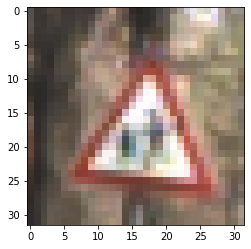

In [4]:
# @student show one image of the batch and its label
print(f"label: {y_batch[1]}")
plt.imshow(x_batch[0].permute(1,2,0))
plt.show()

##### Execution

In order to compare models against each other metrics are calculated on an unseen test dataset.
(It will be uploaded during the exam session)

In this exercise you should try to develop your own model.
If you are new to pytorch, this section of the introduction is about creating your model [PyTorch Create A Model](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).


In [5]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        super().__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.AvgPool2d(kernel_size=2)
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.AvgPool2d(kernel_size=2)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=120),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.Linear(in_features=84, out_features=self.num_classes)

        )

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        logits = self.head(x)
        return logits

For inspiration you can take a look at these ground-breaking publications:
[LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)
[AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
[GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf)
[ResNet](https://arxiv.org/pdf/1512.03385.pdf)
[Vit](https://arxiv.org/abs/2010.11929)

Additionally, you can also add data augmentation to the training data in order to improve the generalization of your model.
[Torchvision Augmentation](https://pytorch.org/vision/stable/transforms.html)

In [6]:
model = LeNet(num_classes=NUM_CLASSES)
print(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

LeNet(
  (stage1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (stage2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=120, bias=True)
    (2): ReLU()
    (3): Dropout1d(p=0.2, inplace=False)
    (4): Linear(in_features=120, out_features=84, bias=True)
    (5): ReLU()
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Linear(in_features=84, out_features=12, bias=True)
  )
)


/home/klemp/miniconda3/envs/mv_assignments/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Below is the training process of the model.
If your machine supports gpu acceleration uncomment line 6.

In [7]:
for epoch in range(20):
    print(f"epoch {epoch+1}")
    pbar = tqdm(enumerate(train_dl))
    running_loss = []
    for i, (imgs, labels) in pbar:
        # @student: uncomment if your machine has GPU support
        #imgs, labels = imgs.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()

        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.detach().numpy())
        pbar.set_description(f"loss {np.mean(running_loss):.3} - " )
        pbar.update()

epoch 1


0it [00:00, ?it/s]/home/klemp/miniconda3/envs/mv_assignments/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
loss 1.8 - : : 433it [00:52,  8.22it/s] 


epoch 2


loss 1.38 - : : 433it [00:33, 12.95it/s]


epoch 3


loss 1.23 - : : 433it [00:33, 12.91it/s]


epoch 4


loss 1.18 - : : 433it [00:31, 13.62it/s]


epoch 5


loss 1.1 - : : 433it [00:35, 12.31it/s] 


epoch 6


loss 1.03 - : : 433it [00:32, 13.34it/s] 


epoch 7


loss 1.01 - : : 433it [00:31, 13.54it/s]


epoch 8


loss 0.995 - : : 433it [00:33, 13.04it/s]


epoch 9


loss 0.95 - : : 433it [00:33, 13.10it/s] 


epoch 10


loss 0.949 - : : 433it [00:28, 15.32it/s]


epoch 11


loss 0.938 - : : 433it [00:26, 16.14it/s]


epoch 12


loss 0.929 - : : 433it [00:26, 16.58it/s]


epoch 13


loss 0.882 - : : 433it [00:30, 14.01it/s]


epoch 14


loss 0.887 - : : 433it [00:29, 14.71it/s]


epoch 15


loss 0.899 - : : 433it [00:25, 17.23it/s]


epoch 16


loss 0.878 - : : 433it [00:26, 16.11it/s]


epoch 17


loss 0.857 - : : 433it [00:21, 20.53it/s]


epoch 18


loss 0.914 - : : 433it [00:20, 21.17it/s]


epoch 19


loss 0.882 - : : 433it [00:22, 19.39it/s]


epoch 20


loss 0.874 - : : 433it [00:21, 19.99it/s]


#### From Logits to Labels

Your network will output logits and not the final predictions.
Hence, you further need to calculate the predicted label based on the logits.

In [8]:
def eval(model, dl):
    y_labels = []
    pred_labels = []
    model.eval()
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dl):
            logits = model(imgs)

            # @student: calculate class predictions based on the logits
            preds = torch.argmax(torch.softmax(logits, dim=-1), dim=-1)

            pred_labels.extend(preds.detach().numpy())
            y_labels.extend(labels.detach().numpy())

    from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
    cm = confusion_matrix(y_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print(f"f1: {f1_score(y_labels, pred_labels, average='macro')}, p: {precision_score(y_labels, pred_labels, average='macro')}, r: {recall_score(y_labels, pred_labels, average='macro')}")

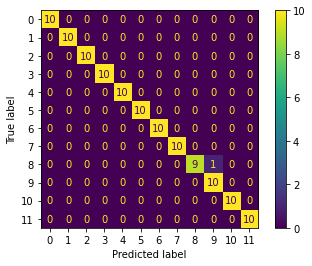

f1: 0.9916457811194653, p: 0.9924242424242423, r: 0.9916666666666667


In [9]:
eval(model, val_dl)

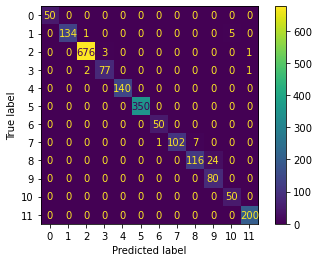

f1: 0.9655762356146372, p: 0.9624986678191251, r: 0.9724670550038197


In [10]:
test_ds = torchvision.datasets.ImageFolder("data_test", transform=v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
]))
test_dl = DataLoader(dataset=test_ds, batch_size=16, shuffle=False)

eval(model, test_dl)